In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

https://pytorch.org/tutorials/beginner/chatbot_tutorial.html?highlight=chatbot#define-evaluation

# Import

In [2]:
from pathlib import Path
import io

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchtext
from torchtext.vocab import build_vocab_from_iterator, GloVe
from nltk.translate import bleu

import torch
from torch import nn

from torch.utils.data import Dataset, DataLoader
from typing import List

/home/riyadh/codes/nlp/learn2ask/venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Look at Data
Data already preprocessed collected from the original repo.

In [3]:
data_root = Path("data/processed")

In [4]:
with open(data_root / "src-train.txt") as f:
    src_train = [line.strip() for line in f]

with open(data_root / "tgt-train.txt") as f:
    tgt_train = [line.strip() for line in f]

with open(data_root / "src-dev.txt") as f:
    src_dev = [line.strip() for line in f]

with open(data_root / "tgt-dev.txt") as f:
    tgt_dev = [line.strip() for line in f]

with open(data_root / "src-test.txt") as f:
    src_test = [line.strip() for line in f]

with open(data_root / "tgt-test.txt") as f:
    tgt_test = [line.strip() for line in f]

print(len(src_train), len(src_dev), len(src_test))

70484 10570 11877


# Vocabulary

In [5]:
import datahandler as dh

In [6]:
vocab = dh.load_and_build_vocab(
    data_root / "src-train.txt", data_root / "tgt-train.txt"
)

In [7]:
pad_index = vocab["<PAD>"]
sos_index = vocab["<SOS>"]
eos_index = vocab["<EOS>"]

In [8]:
# a tensor of shape (vocab_size, embedding_dim)
embedding_vector = dh.load_pretrained_glove(vocab, cache="data/")

# Batch Dataloader

In [9]:
config = {"src_max_seq": 150, "tgt_max_seq": 50, "batch_size": 32}

In [10]:
from tokenization import Tokenizer

In [11]:
tokenizer = Tokenizer(vocab, pad_index, sos_index, eos_index)

src_train_tensor = tokenizer.encode(src_train, max_seq=config["src_max_seq"])
tgt_train_tensor = tokenizer.encode(
    tgt_train, add_sos=True, add_eos=True, max_seq=config["tgt_max_seq"]
)

src_test_tensor = tokenizer.encode(src_test, max_seq=config["src_max_seq"])
tgt_test_tensor = tokenizer.encode(
    tgt_test, add_sos=True, add_eos=True, max_seq=config["tgt_max_seq"]
)

src_dev_tensor = tokenizer.encode(src_dev, max_seq=config["src_max_seq"])
tgt_dev_tensor = tokenizer.encode(
    tgt_dev, add_sos=True, add_eos=True, max_seq=config["tgt_max_seq"]
)

In [12]:
print(src_train_tensor.shape, tgt_train_tensor.shape)
print(src_train_tensor[0])

torch.Size([70484, 150]) torch.Size([70484, 50])
tensor([  11, 2226,  162,    3,  162,    5,   28,  145,  184,   15,    5,  583,
          36,  220,    5,   11,  401,  184,    5,   49,   15,   95,   11,  145,
         184,  142,   33,   15, 3950,   10, 2706, 2610,   10,    4,  149,  145,
           7,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    

In [13]:
tokenizer.decode(src_train_tensor[0].unsqueeze(dim=0), keep_specials=False)

['a pub / <UNK> / , or public house is , despite its name , a private house , but is called a public house because it is licensed to sell alcohol to the general public .']

In [14]:
src_train[0]

'a pub / pʌb / , or public house is , despite its name , a private house , but is called a public house because it is licensed to sell alcohol to the general public .'

In [15]:
class SentenceQuestionDataset(Dataset):
    def __init__(
        self,
        sentences: torch.Tensor,
        questions: torch.Tensor,
    ):
        """
        Represents a dataset of text pairs for training or evaluating models that
        deal with relationships between text passages.

        Args:
            vocab (torchtext.vocab.Vocab): A pre-built vocabulary object
                containing word mappings from text to numerical representation.
            sentences (List[str]): A list of text passages (sentences, paragraphs, etc.).
            questions (List[str]): A list of corresponding questions related to the sentences.
            Ls (int, optional): The maximum length to which sentences will be
                truncated or padded during preprocessing (default: 150).
            Lq (int, optional): The maximum length to which questions will be
                truncated or padded during preprocessing (default: 50).
        """
        self.sentences = sentences
        self.questions = questions

    def __len__(self):
        return self.sentences.size(0)

    def __getitem__(self, index):
        return (self.sentences[index], self.questions[index])

In [16]:
train_ds = SentenceQuestionDataset(src_train_tensor, tgt_train_tensor)
test_ds = SentenceQuestionDataset(src_test_tensor, tgt_train_tensor)
dev_ds = SentenceQuestionDataset(src_dev_tensor, tgt_dev_tensor)

In [17]:
train_dl = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)
print(len(train_dl))
dev_dl = DataLoader(dev_ds, batch_size=8, shuffle=False)

2203


# Models

In [18]:
from models import Encoder, Decoder, Seq2SeqEncoderDecoder

# Trainer

In [19]:
from trainer import Trainer

In [68]:
config["lr"] = 1.0
net = Seq2SeqEncoderDecoder(
    len(vocab),
    embedding_vector,
    300,
    vocab["<PAD>"],
    vocab["<SOS>"],
    vocab["<EOS>"],
    8,
    True,
)
optim = torch.optim.SGD(net.parameters(), lr=config["lr"])

trainer = Trainer(
    net,
    optim,
    train_dl,
    len(vocab),
    config["lr"],
    dev_dl,
    enable_checkpoint=True,
    limit_on_train_batch=2,
    enable_comet=True,
    comet_project="learn-to-ask-paper",
    comet_experiment_name=None,
    cfg=config,
    validation_data=tgt_dev,
    tokenizer=tokenizer,
)

trainer.fit(10)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/riyadhrazzaq/learn-to-ask-paper/963fbae56e1848a9b400a49ecd80f53d
COMET INFO:   Metrics:
COMET INFO:     train/loss : 9.851862589518229
COMET INFO:     val/bleu   : 0
COMET INFO:     val/loss   : 6.179286003112793
COMET INFO:   Others:
COMET INFO:     Name : None
COMET INFO:   Parameters:
COMET INFO:     batch_size  : 32
COMET INFO:     lr          : 1.0
COMET INFO:     src_max_seq : 150
COMET INFO:     tgt_max_seq : 50
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COME

Epoch: 1,	Training loss: 10.079211870829264,	Validation metric: 0	Time elapsed: 6.41 s


  0%|                                                                                                                        | 2/2203 [00:05<1:49:17,  2.98s/batch, loss=3.96]


Epoch: 2,	Training loss: 6.196401993433635,	Validation metric: 0	Time elapsed: 6.20 s


  0%|                                                                                                                        | 2/2203 [00:06<1:51:51,  3.05s/batch, loss=3.07]


Epoch: 3,	Training loss: 3.297871748606364,	Validation metric: 0	Time elapsed: 6.33 s


  0%|                                                                                                                        | 2/2203 [00:05<1:49:47,  2.99s/batch, loss=3.34]


Epoch: 4,	Training loss: 3.396534283955892,	Validation metric: 0	Time elapsed: 6.23 s


  0%|                                                                                                                        | 2/2203 [00:05<1:49:59,  3.00s/batch, loss=3.07]


Epoch: 5,	Training loss: 3.195185581843058,	Validation metric: 0	Time elapsed: 6.24 s


  0%|                                                                                                                        | 2/2203 [00:06<1:50:43,  3.02s/batch, loss=3.29]


Epoch: 6,	Training loss: 3.298307736714681,	Validation metric: 0	Time elapsed: 6.27 s


  0%|                                                                                                                        | 2/2203 [00:06<1:52:00,  3.05s/batch, loss=3.16]


Epoch: 7,	Training loss: 3.148374557495117,	Validation metric: 0	Time elapsed: 6.37 s


  0%|                                                                                                                        | 2/2203 [00:05<1:45:08,  2.87s/batch, loss=3.32]


Epoch: 8,	Training loss: 3.259620189666748,	Validation metric: 0	Time elapsed: 5.97 s


  0%|                                                                                                                        | 2/2203 [00:05<1:49:12,  2.98s/batch, loss=3.12]


Epoch: 9,	Training loss: 3.055701573689779,	Validation metric: 0	Time elapsed: 6.19 s


  0%|                                                                                                                        | 2/2203 [00:05<1:49:24,  2.98s/batch, loss=3.41]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/riyadhrazzaq/learn-to-ask-paper/f3be32d50be64414b8cb04d528089b0a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train/loss [10] : (3.055701573689779, 10.079211870829264)
COMET INFO:     val/bleu        : 0
COMET INFO:     val/loss [10]   : (2.6718029975891113, 8.08183479309082)
COMET INFO:   Others:
COMET INFO:     Name : None
COMET INFO:   Parameters:
COMET INFO:     batch_size  : 32
COMET INFO:     lr          : 1.0
COMET INFO:     src_max_seq 

Epoch: 10,	Training loss: 3.3318992455800376,	Validation metric: 0	Time elapsed: 6.20 s


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


In [65]:
i = 0
for batch in dev_dl:
    token_ids, _ = net.generate(batch[0], max_seq=config["tgt_max_seq"])
    print(
        tokenizer.decode(batch[1], keep_specials=False)[0],
        tgt_dev[i : i + dev_dl.batch_size][0],
    )
    print()
    i += dev_dl.batch_size

which nfl team represented the afc at super bowl 50 ? which nfl team represented the afc at super bowl 50 ?

what was the theme of super bowl 50 ? what was the theme of super bowl 50 ?

what year did the denver broncos secure a super bowl title for the third time ? what year did the denver broncos secure a super bowl title for the third time ?

who won super bowl 50 ? who won super bowl 50 ?

what year was the carolina panthers franchise founded ? what year was the carolina panthers franchise founded ?

what was the <UNK> ratio in 2015 for the carolina panthers during their regular season ? what was the win/loss ratio in 2015 for the carolina panthers during their regular season ?

who did denver beat in the afc championship ? who did denver beat in the afc championship ?

how many <UNK> did von miller force in super bowl 50 ? how many fumbles did von miller force in super bowl 50 ?

how many <UNK> did von miller force ? how many fumbles did von miller force ?

how many times did the d

KeyboardInterrupt: 

In [62]:
len(dev_dl)

1322

# Working trainer method

  0%|▎                                                                                                                       | 6/2203 [00:15<1:31:32,  2.50s/batch, loss=3.21]


epoch 1 loss 7.20052973429362


  0%|▎                                                                                                                       | 6/2203 [00:14<1:28:51,  2.43s/batch, loss=3.05]

epoch 2 loss 3.82867169380188


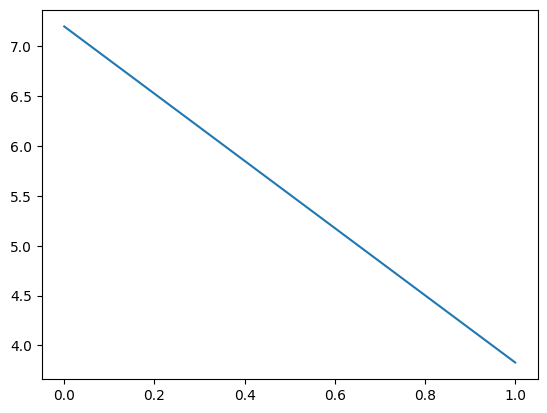

In [65]:
def train_epoch(model, optimizer, max_step=float("inf")):
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    bar = tqdm(train_dl, unit="batch")

    for step, data in enumerate(bar):
        optimizer.zero_grad()
        logits, scores = model(data[0], data[1][:, :-1])
        final_logits = torch.cat(logits, dim=0).view(
            logits[0].size(0), -1, logits[0].size(1)
        )
        loss = criterion(final_logits.transpose(1, 2), data[1][:, 1:])
        bar.set_postfix(**{"loss": loss.item()})

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # early exit, needed during development
        if step > max_step:
            break

    return total_loss / step


model = Seq2SeqEncoderDecoder(
    len(vocab),
    embedding_vector,
    300,
    vocab["<PAD>"],
    vocab["<SOS>"],
    vocab["<EOS>"],
    8,
    True,
)
optim = torch.optim.SGD(model.parameters(), lr=1.0)

losses = []
for i in range(1, 3):
    loss = train_epoch(model, optim, max_step=5)
    print("epoch", i, "loss", loss)
    losses.append(loss)

plt.plot(losses)

In [35]:
source = next(iter(dev_dl))

In [45]:
outputs = model.generate(source[0])[0]
outputs = tokenizer.decode(outputs, keep_specials=False)

In [39]:
from nltk.translate.bleu_score import corpus_bleu

In [57]:
corpus_bleu(list_of_references=tgt_dev[0:8], hypotheses=outputs)

0

In [60]:
a = torch.ones((5, 3))
a[:, 2] = a[:, 2] / 5
a[]

tensor([[1.0000, 1.0000, 0.2000],
        [1.0000, 1.0000, 0.2000],
        [1.0000, 1.0000, 0.2000],
        [1.0000, 1.0000, 0.2000],
        [1.0000, 1.0000, 0.2000]])

In [72]:
tgt_dev

['which nfl team represented the afc at super bowl 50 ?',
 'which nfl team represented the nfc at super bowl 50 ?',
 'where did super bowl 50 take place ?',
 'which nfl team won super bowl 50 ?',
 'what color was used to emphasize the 50th anniversary of the super bowl ?',
 'what was the theme of super bowl 50 ?',
 'what day was the game played on ?',
 'what is the afc short for ?',
 'what was the theme of super bowl 50 ?',
 'what does afc stand for ?',
 'what day was the super bowl played on ?',
 'who won super bowl 50 ?',
 'what venue did super bowl 50 take place in ?',
 'what city did super bowl 50 take place in ?',
 'if roman numerals were used , what would super bowl 50 have been called ?',
 'super bowl 50 decided the nfl champion for what season ?',
 'what year did the denver broncos secure a super bowl title for the third time ?',
 'what city did super bowl 50 take place in ?',
 'what stadium did super bowl 50 take place in ?',
 'what was the final score of super bowl 50 ?',
 'w